<a href="https://colab.research.google.com/github/Kyriezxc/CIS522_Project/blob/Zhiyu_experiments/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Colab Notebooks/CIS522_Project"

/content/drive/MyDrive/Colab Notebooks/CIS522_Project


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train = pd.read_csv("data/train.csv")

In [4]:
# Filter missing data and useless columns
train = train[train["MISSING_DATA"] == False]
train = train[train["POLYLINE"].map(len) > 1]
train = train[train["POLYLINE"] != "[]"]
train = train[["POLYLINE"]]
# Choose 10000 rows randomly from dataset to run
train_1 = train.sample(10000, random_state=2023)

train_1

,POLYLINE
673744,"[[-8.612595,41.146191],[-8.611551,41.146119],[..."
1541850,"[[-8.628831,41.160978],[-8.628831,41.160987],[..."
1547523,"[[-8.613225,41.166801],[-8.613324,41.166684],[..."
775649,"[[-8.569674,41.160771],[-8.569665,41.160897],[..."
1384848,"[[-8.56656,41.153265],[-8.566524,41.153292],[-..."
...,...
899301,"[[-8.627877,41.14467],[-8.629929,41.145093],[-..."
1010655,"[[-8.608887,41.147487],[-8.608185,41.147784],[..."
1665872,"[[-8.608707,41.147802],[-8.608527,41.147766],[..."
712884,"[[-8.614125,41.146209],[-8.614107,41.146218],[..."


# Pre-processing

In [5]:
def _change_type(polyline):
    polyline = polyline[2:-2]
    cords_raw = polyline.split("],[")
    cords = []
    max_lon, min_lon, max_lat, min_lat = float("-inf"), float("inf"), float("-inf"), float("inf")
    for cord in cords_raw:
        cords.append([float(loc) for loc in cord.split(",")])
        max_lon = max(max_lon, cords[-1][0])
        min_lon = min(min_lon, cords[-1][0])
        max_lat = max(max_lat, cords[-1][1])
        min_lat = min(min_lat, cords[-1][1])
    return pd.Series({"POLYLINE": cords, "max_lon": max_lon, "min_lon": min_lon, "max_lat": max_lat, "min_lat": min_lat})

In [6]:
def filter_map(train, max_lat, min_lat, max_lon, min_lon):
    train.reset_index(drop=True, inplace=True)
    return train[(train["max_lat"] <= max_lat) & (train["min_lat"] >= min_lat) &
                 (train["max_lon"] <= max_lon) & (train["min_lon"] >= min_lon)]

In [7]:
def _normalize(polyline, max_lon, min_lon, max_lat, min_lat):
    final = [[(cord[0]-min_lon)/(max_lon-min_lon), (cord[1] - min_lat) / (max_lat - min_lat)] for cord in polyline]
    return pd.Series({"POLYLINE_INIT": final[:-1], "POLYLINE_DEST": final[-1]})

In [8]:
def _to_matrix(polyline, m):
    mat = np.zeros((m, m))
    n = len(polyline)
    for i in range(n):
        x = min(m - 1, int(polyline[i][0] * m))
        y = min(m - 1, int(polyline[i][1] * m))
        mat[y][x] = (i + 1) / n
    return mat

In [9]:
def transform(df_train, m):
    # Change type
    changed = df_train["POLYLINE"].apply(_change_type)
    # Filter map for max/min long/lat
    changed = filter_map(changed, 41.2, 41, -8.6, -8.7)
    # Get min-max
    max_longitude = changed["max_lon"].max()
    min_longitude = changed["min_lon"].min()
    max_latitude = changed["max_lat"].max()
    min_latitude = changed["min_lat"].min()
    # Normalize min-max and split
    cleaned = changed["POLYLINE"].apply(_normalize, args=(max_longitude, min_longitude, max_latitude, min_latitude))
    # Transform to matrices
    cleaned["MATRIX"] = cleaned["POLYLINE_INIT"].apply(_to_matrix, args=(m,))
    return cleaned

In [10]:
transformed = transform(train_1, 40)
len(transformed)

5809

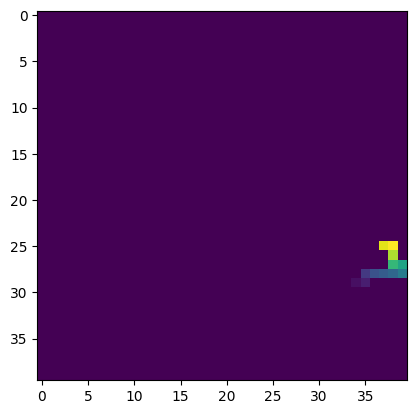

In [11]:
mat = transformed["MATRIX"].iloc[0]

plt.imshow(mat)
plt.show()

In [12]:
transformed.head()

,POLYLINE_INIT,POLYLINE_DEST,MATRIX
0,"[[0.8742342342342228, 0.7259990813045455], [0....","[0.9612612612612519, 0.6409738171795833]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[[0.7117117117117076, 0.8014699127239199], [0....","[0.6336036036035904, 0.7591180523656118]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.8679279279279241, 0.831189710610917], [0.8...","[0.8209009009009027, 0.7312356453835327]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,"[[0.5051351351351239, 0.7669269637115131], [0....","[0.824144144144137, 0.7284795590261557]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,"[[0.27891891891891146, 0.9078548461184808], [0...","[0.7655855855855725, 0.8426734037666541]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


# Model Experiments

In [13]:
def sequence2tensor(sequence, seqlen=200):
    if len(sequence) > seqlen:
        sequence = sequence[-seqlen:]
    tensor = torch.zeros(seqlen, 3)
    for i, point in enumerate(sequence, start=seqlen-len(sequence)):
        tensor[i, :2] = torch.Tensor(point)
        tensor[i, 2] = 1  # 1 for in the sequence, 0 for out of the sequence
    return tensor

def matrix2tensor(matrix):
    return torch.Tensor(matrix)

def output2tensor(output):
    return torch.Tensor(output)

In [14]:
sequence_tensor = transformed["POLYLINE_INIT"].apply(sequence2tensor).values
matrix_tensor = transformed["MATRIX"].apply(matrix2tensor).values
output_tensor = transformed["POLYLINE_DEST"].apply(output2tensor).values

In [15]:
sequence_tensor[0]

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.000

In [16]:
matrix_tensor[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
output_tensor[0]

tensor([0.9613, 0.6410])

In [18]:
seq_train, seq_valid, mat_train, mat_valid, out_train, out_valid = \
train_test_split(sequence_tensor, matrix_tensor, output_tensor, test_size=0.2, random_state=2023)

In [35]:
def train_model(model, criterion, train_loader, valid_loader, learning_rate=0.001, epochs=20, device=DEVICE):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = []
        for in_, out in tqdm(train_loader):
            in_, out = in_.to(device), out.to(device)
            optimizer.zero_grad()
            pred = model(in_)
            loss = criterion(pred, out)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_losses.append(np.mean(train_loss))
        print("Train loss: {}".format(train_losses[-1]))
        model.eval()
        valid_loss = []
        for in_, out in valid_loader:
            in_, out = in_.to(device), out.to(device)
            pred = model(in_)
            loss = criterion(pred, out)
            valid_loss.append(loss.item())
        valid_losses.append(np.mean(valid_loss))
        print("Validation loss: {}".format(valid_losses[-1]))
    plt.figure()
    plt.plot(train_losses, color="blue")
    plt.plot(valid_losses, color="red")
    plt.show()

## Simple RNN

In [36]:
class SequenceDataset(Dataset):
    def __init__(self, sequence, output):
        self.sequence = sequence
        self.output = output

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        return self.sequence[idx], self.output[idx]

In [37]:
train_data = SequenceDataset(seq_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = SequenceDataset(seq_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [38]:
class RNN(nn.Module):
    def __init__(self, i_size=3, h_size=6, n_layers=1, o_size=2, activation="relu"):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            nonlinearity = activation,
            batch_first = True
        )
        self.out = nn.Linear(h_size, o_size)
        
    def forward(self, x):
        out, h = self.rnn(x, None)  # None represents zero initial hidden state
        return torch.sigmoid(self.out(out[:, -1, :]))  # choose last time step of output

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.31260117765975326
Validation loss: 0.28365683869311686


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.2719361890260487
Validation loss: 0.2536023282691052


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.23489042830793824
Validation loss: 0.180446752592137


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.12102364166958691
Validation loss: 0.10685970398940538


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.08241474240610044
Validation loss: 0.05786273804934401


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0544539894143196
Validation loss: 0.053270270361712106


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04992895057960732
Validation loss: 0.049296065772834574


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.047947473466804585
Validation loss: 0.048534226652823


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04671630304153651
Validation loss: 0.046830898248835615


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04567829983895772
Validation loss: 0.04593751344241594


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04504157842634476
Validation loss: 0.046366329255856965


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04451164419520391
Validation loss: 0.04499575966282895


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04424755994791854
Validation loss: 0.04499300059519316


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04359107617646048
Validation loss: 0.04452629661873767


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04304902332082187
Validation loss: 0.04381250256770536


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04261610417129242
Validation loss: 0.044467143322292124


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04220566245382779
Validation loss: 0.0434211790561676


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04229327551510236
Validation loss: 0.04373986862207714


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04159988297072992
Validation loss: 0.042104740872194894


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.041516188174894414
Validation loss: 0.042370206823474484


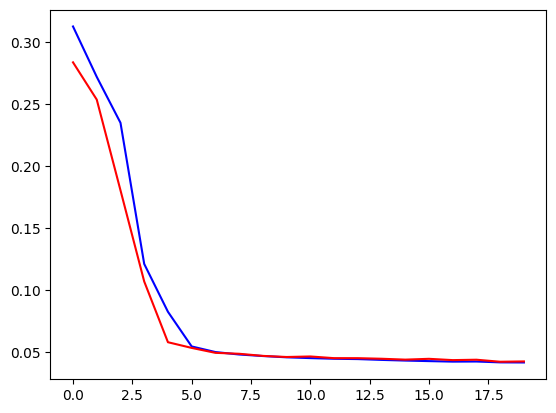

In [45]:
rnn = RNN(3, 6, 1, 2)
train_model(rnn, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.002)

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.07250783097458212
Validation loss: 0.04721108020136231


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.031910700162183746
Validation loss: 0.02467542406367628


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.025623418952095998
Validation loss: 0.02379185176993671


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.024214317562849554
Validation loss: 0.02155611806206013


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.022505634885332356
Validation loss: 0.020420949023805167


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.019960225240824973
Validation loss: 0.016455240547657013


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.015461536800514345
Validation loss: 0.012049233295807713


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.011074238252660183
Validation loss: 0.008643518606396882


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.008979136749387604
Validation loss: 0.007240696369033111


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.007858498242033059
Validation loss: 0.006674509213649128


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.00732732627681163
Validation loss: 0.0061975234237156415


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.007010118487252764
Validation loss: 0.0061232399219941155


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.006735369435524287
Validation loss: 0.005934713579910367


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0065568815948671266
Validation loss: 0.005772656038109409


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.00640512567192112
Validation loss: 0.006052912408976178


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.006243454187164364
Validation loss: 0.005445681879983137


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0061364533213821995
Validation loss: 0.0058252621368554075


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0059967164224498486
Validation loss: 0.005330203419649287


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.00583097745970606
Validation loss: 0.00526176760659406


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.005733319277530664
Validation loss: 0.00561891743717225


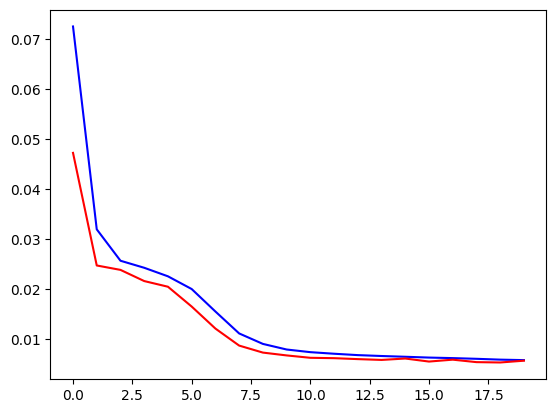

In [46]:
rnn = RNN(3, 6, 1, 2)
train_model(rnn, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

## MLP with matrix input

In [47]:
class MatrixDataset(Dataset):
    def __init__(self, matrix, output):
        self.matrix = matrix
        self.output = output

    def __len__(self):
        return len(self.matrix)

    def __getitem__(self, idx):
        return self.matrix[idx], self.output[idx]

In [48]:
train_data = MatrixDataset(mat_train, out_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = MatrixDataset(mat_valid, out_valid)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

In [49]:
class MLP(nn.Module):
    def __init__(self, i_size=40*40, h_size=100, h_layers=2, o_size=2):
        super(MLP, self).__init__()
        self.hiddens = nn.Sequential()
        for i in range(h_layers):
            if i == 0:
                hidden = nn.Sequential(nn.Linear(i_size, h_size), nn.Dropout(), nn.ReLU())
            else:
                hidden = nn.Sequential(nn.Linear(h_size, h_size), nn.Dropout(), nn.ReLU())
            self.hiddens.append(hidden)
        self.out = nn.Linear(h_size, o_size)
        
    def forward(self, x):
        x = x.flatten(1)
        for hidden in self.hiddens:
            x = hidden(x)
        return torch.sigmoid(self.out(x))

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.13462036113216452
Validation loss: 0.05308763957337329


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.06342768944697837
Validation loss: 0.04095090533557691


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.05715530166683132
Validation loss: 0.039021081536224016


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.053431251022505434
Validation loss: 0.03722091195614714


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0511620175858883
Validation loss: 0.03529020918435172


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.050242531789492256
Validation loss: 0.035385704942439734


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.047864751558597776
Validation loss: 0.03595603129973537


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.046936168246073266
Validation loss: 0.034053934051802286


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04562223360758938
Validation loss: 0.032952189445495605


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04417965459088757
Validation loss: 0.03240546339044446


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.043812444152897353
Validation loss: 0.03206632051028704


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.042915096021678346
Validation loss: 0.030949597393995838


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.042272349589899796
Validation loss: 0.03220350775671633


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.041285064683793345
Validation loss: 0.031040175180686146


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0402968628969911
Validation loss: 0.03127885943180636


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.04005861154770198
Validation loss: 0.030499689673122606


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.039214034322394085
Validation loss: 0.030010217604668515


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.038385940639123525
Validation loss: 0.03081793191009446


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.03854468485263929
Validation loss: 0.029993249495562754


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.037729956388269384
Validation loss: 0.030356755578204206


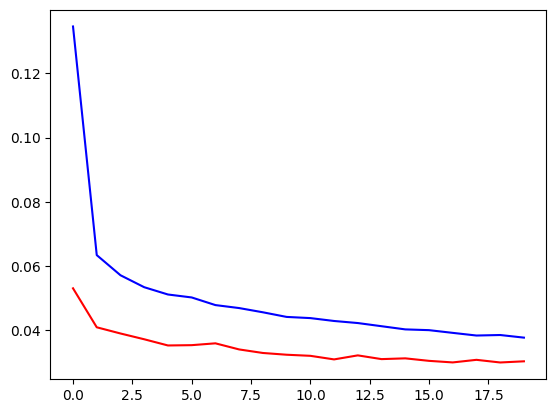

In [50]:
mlp = MLP()
train_model(mlp, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.002)

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.033301989956159295
Validation loss: 0.007735663338711387


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.009008687365902206
Validation loss: 0.0051280334714407984


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.007157434990042693
Validation loss: 0.004398973603536816


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.006203819410747861
Validation loss: 0.004103522318856497


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.005880949163988029
Validation loss: 0.003979627398381892


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.005484864323029984
Validation loss: 0.0037362574183038974


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.005176632161162896
Validation loss: 0.003687349270637098


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.004933720642751823
Validation loss: 0.0036297428274625226


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.004639521218861823
Validation loss: 0.0035661979897045775


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.004397515832663399
Validation loss: 0.0035396280122528736


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0043777801026271225
Validation loss: 0.0035001772370091395


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0042247878106897825
Validation loss: 0.0035861649391192353


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0039862488868505986
Validation loss: 0.003304903977550566


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003974495769784569
Validation loss: 0.003344003000835839


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0038467191880543344
Validation loss: 0.003123249391424715


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003953094319886949
Validation loss: 0.0031200775656064876


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003673484628662875
Validation loss: 0.0030870989308153327


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0036625694467571296
Validation loss: 0.0030676146944690692


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003645209308509549
Validation loss: 0.0037558887239643617


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003556189057098268
Validation loss: 0.003042836943151135


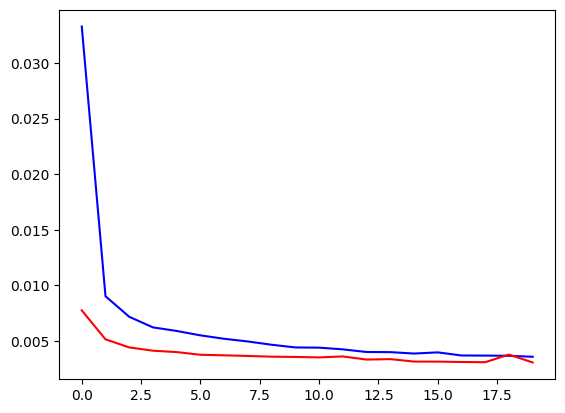

In [51]:
mlp = MLP()
train_model(mlp, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)

## CNN

In [52]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        #self.conv2 = nn.Conv2d(32, 64, 3, 1)
        #self.fc1 = nn.Linear(20736, 128)
        #self.fc1 = nn.Linear(82944, 128)
        self.fc1 = nn.Linear(46208, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = nn.functional.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.21097820537955794
Validation loss: 0.15518511988614736


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.08824682664381314
Validation loss: 0.1217362692481593


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.062227836006308254
Validation loss: 0.06254401626555543


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.046163530586517024
Validation loss: 0.03745829882590394


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.037161188838008334
Validation loss: 0.03704437044890303


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.03585728791172374
Validation loss: 0.03623828360516774


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0408169582537184
Validation loss: 0.03795334128172774


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.03174616927153444
Validation loss: 0.029873443375292578


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.03236839042542732
Validation loss: 0.045908638717312565


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.030823047387681594
Validation loss: 0.029192976653575897


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.029112571161495498
Validation loss: 0.03767281476604311


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.03185870036584874
Validation loss: 0.02877183317353851


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.026021278578124633
Validation loss: 0.028969389435492064


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.024688229526150716
Validation loss: 0.0319727783728587


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.022880948033847222
Validation loss: 0.02637084367636003


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.028082644235189646
Validation loss: 0.02751484101540164


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.02569821193712215
Validation loss: 0.02615254558622837


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.025114179410244505
Validation loss: 0.03193314569561105


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.02703557935326475
Validation loss: 0.026446283255752764


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.021148809423185373
Validation loss: 0.022359653327025865


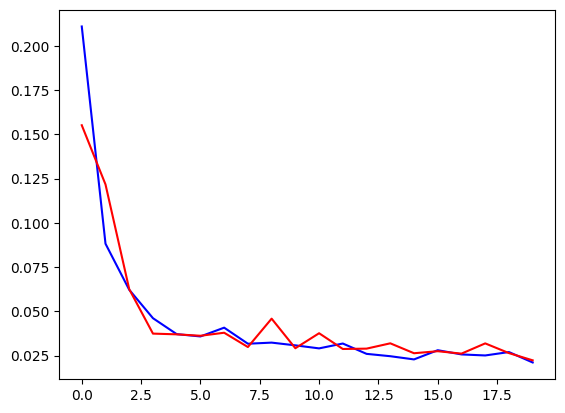

In [54]:
cnn = CNN()
train_model(cnn, nn.L1Loss(), train_loader, valid_loader, learning_rate=0.001)

  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.18895091765802607
Validation loss: 0.008553306229020419


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0064279269140009605
Validation loss: 0.004736011719184094


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.005762729777839698
Validation loss: 0.0048491301897325015


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.004299977110150232
Validation loss: 0.0038720589057591403


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0036195340990535403
Validation loss: 0.0034747572591234195


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003371404442451384
Validation loss: 0.0034204099119003665


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0031658341384122836
Validation loss: 0.0030061752094249976


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.002917106469059746
Validation loss: 0.003983942019802175


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.002886470574694239
Validation loss: 0.0028297629048067486


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.002493336133352698
Validation loss: 0.002770118556279493


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.007741760153144802
Validation loss: 0.009563487219183068


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003588549405247075
Validation loss: 0.004229407818791897


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.002460434362260395
Validation loss: 0.003196513678535427


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0020459901632371115
Validation loss: 0.0024349424669421033


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.003439064656722372
Validation loss: 0.004268332972730461


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0022136313052950043
Validation loss: 0.0023784909158405896


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.001868861971410272
Validation loss: 0.0025557441465360554


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.01493126264460742
Validation loss: 0.006448535248637199


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.010956811865357912
Validation loss: 0.00405997248660577


  0%|          | 0/73 [00:00<?, ?it/s]

Train loss: 0.0033366635636337206
Validation loss: 0.0035455744272392046


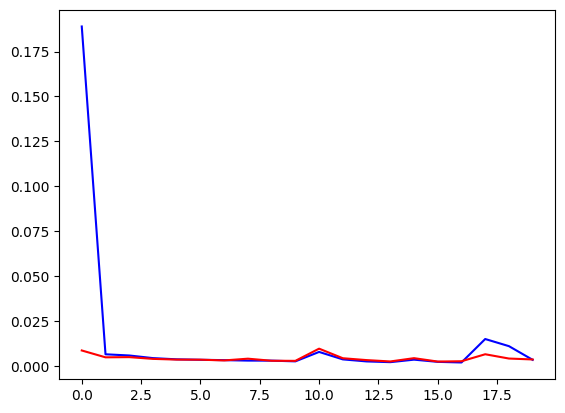

In [55]:
cnn = CNN()
train_model(cnn, nn.MSELoss(), train_loader, valid_loader, learning_rate=0.001)